In [1]:
%matplotlib widget

import jax
import jax.numpy as jnp
import numpy as onp
import optax
import matplotlib.pyplot as plt
import itertools

import jaxlayerlumos as jll
import jaxlayerlumos.utils_materials as jll_utils_materials
import jaxlayerlumos.utils_spectra as jll_utils_spectra
import jaxlayerlumos.utils_units as jll_utils_units
import jaxlayerlumos.colors.composite as jll_colors_composite

In [2]:
str_mode = "reflection"
materials = ["Air", "TiO2", "Ag", "TiO2", "FusedSilica"]
num_layers = len(materials) - 2

num_grids = 5
bound_thickness = [5, 50]

In [3]:
frequencies = jll_utils_spectra.get_frequencies_visible_light()
wavelengths = jll_utils_spectra.convert_frequencies_to_wavelengths(frequencies)
wavelengths_in_nm = wavelengths / jll_utils_units.get_nano()

n_k = jll_utils_materials.get_n_k(materials, frequencies)

print(f"frequencies.shape {frequencies.shape}")
print(f"wavelengths.shape {wavelengths.shape}")
print(f"wavelengths_in_nm.shape {wavelengths_in_nm.shape}")
print(f"n_k.shape {n_k.shape}")

frequencies.shape (1001,)
wavelengths.shape (1001,)
wavelengths_in_nm.shape (1001,)
n_k.shape (1001, 5)


In [4]:
def get_spectrum(thicknesses):
    angles = jnp.array([0.0])
    thicknesses = jnp.concatenate([
        jnp.array([0]),
        thicknesses,
        jnp.array([0])
    ], axis=0)
    thicknesses *= jll_utils_units.get_nano()

    R_TE, T_TE, R_TM, T_TM = jll.stackrt(n_k, thicknesses, frequencies, thetas=angles)

    R_TE = R_TE[0]
    T_TE = T_TE[0]
    R_TM = R_TM[0]
    T_TM = T_TM[0]

    if str_mode == "transmission":
        spectrum = (T_TE + T_TM) / 2
    elif str_mode == "reflection":
        spectrum = (R_TE + R_TM) / 2
    else:
        raise ValueError

    return spectrum

In [5]:
thicknesses = jnp.linspace(bound_thickness[0], bound_thickness[1], num_grids)
all_combinations = jnp.array(list(itertools.product(thicknesses, repeat=num_layers)))

print(all_combinations.shape)

(125, 3)


In [6]:
sRGBs = []

for combination in all_combinations:
    spectrum = get_spectrum(combination)
    sRGB = jll_colors_composite.spectrum_to_sRGB(wavelengths_in_nm, spectrum, use_clipping=True)
    sRGBs.append(sRGB)

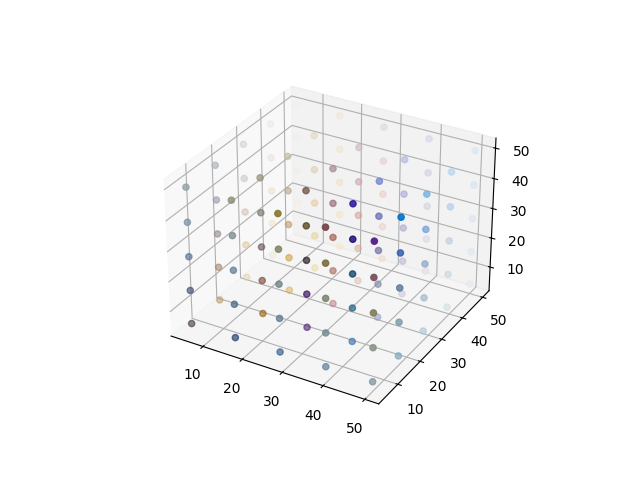

In [7]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.scatter(all_combinations[:, 0], all_combinations[:, 1], all_combinations[:, 2], c=sRGBs)